<h1>Revisiting the ML model to refine the feature set to make the output more meaningful through segmentation</h1>
<p>This notebook looks at factors influencing goalie performance (save percentage) and the injury (via t_tests) implementing them in a Logistic Regression ml model</p>

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import stats
import sqlite3
from joblib import dump, load
pd.set_option('display.max_rows', 500)

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [2]:
DB = "../assests/hockey_data_goalies.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

<h2>Import the existing model, excluding players with no injuries (to prevent bias)</h2>

In [23]:
#import data
goalie_data =pd.read_csv('advancedgoaliestats_withadditionalgoalies.csv')
goalie_data.drop(columns=['Unnamed: 0'],inplace=True)
gd_players = goalie_data.groupby('player_id').max()
#get list of players with one reported injury
player_inj_list = gd_players[gd_players['injured']==1].index
goalie_data_inj = pd.DataFrame(columns=goalie_data.columns)
#train model on players from this list
for players in player_inj_list:
    goalie_data_inj = goalie_data_inj.append(goalie_data[goalie_data['player_id']==players].copy())
goalie_data_inj[['rest_days','shots_against','sa3W','pre_inj','injured']] = goalie_data_inj[['rest_days','shots_against','sa3W','pre_inj','injured']].astype(int)
#goalie_data_inj.loc[goalie_data_inj['pre_inj']>=1,'pre_inj'] = 1


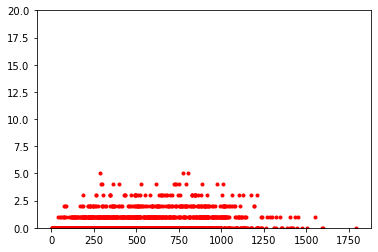

age            rest_days        min_season  \
                       mean       sum       mean  sum         mean   
player_id season                                                     
allenja01 2013    22.598071   316.373   5.357143   75   417.442857   
          2014    24.308667   437.556   3.888889   70   543.727778   
          2015    25.018383  1175.864   3.936170  185  1117.025532   
          2016    26.014822  1170.667   3.844444  173  1334.011111   
          2017    26.918266  1722.769   2.906250  186  1707.685938   
...                     ...       ...        ...  ...          ...   
zatkoje01 2013    26.472250   211.778   9.875000   79   261.068750   
          2014    26.739636   294.136   9.545455  105   815.927273   
          2015    28.487500   227.900   7.875000   63   228.785417   
          2016    29.165462   379.151  13.230769  172   345.223077   
          2017    29.611500   118.446  11.000000   44   466.616667   

                                shots_against         save_pct          ...  \
                            sum          mean    sum      mean     sum  ...   
player_id season                                                        ...   
allenja01 2013      5844.200000    180.000000   2520  0.884143  12.378  ...   
          2014      9787.100000    239.555556   4312  0.922500  16.605  ...   
          2015     52500.200000    511.297872  24031  0.917277  43.112  ...   
          2016     60030.500000    619.888889  27895  0.912378  41.057  ...   
          2017    109291.900000    809.359375  51799  0.909156  58.186  ...   
...                         ...           ...    ...       ...     ...  ...   
zatkoje01 2013      2088.550000    120.000000    960  0.870625   6.965  ...   
          2014      8975.200000    406.090909   4467  0.911182  10.023  ...   
          2015      1830.283333    143.375000   1147  0.936500   7.492  ...   
          2016      4487.900000    181.692308   2362  0.900077  11.701  ...   
          2017      1866.466667    198.250000    793  0.885750   3.543  ...   

                        sa3W         svepct3W            future_save_pct  \
                        mean    sum      mean        sum            mean   
player_id season                                                           
allenja01 2013     75.928571   1063  0.884830  12.387627        0.882571   
          2014    113.111111   2036  0.908922  16.360588        0.889000   
          2015    135.361702   6362  0.922644  43.364251        0.915170   
          2016    157.088889   7069  0.904918  40.721297        0.896222   
          2017    168.078125  10757  0.909159  58.186152        0.910734   
...                      ...    ...       ...        ...             ...   
zatkoje01 2013     41.750000    334  0.913748   7.309984        0.919625   
          2014     68.272727    751  0.907262   9.979883        0.910273   
          2015     63.750000    510  0.924913   7.399307        0.932500   
          2016     30.076923    391  0.912903  11.867733        0.869077   
          2017     31.500000    126  0.858670   3.434680        0.860500   

                           pre_inj        injured      
                     sum      mean  sum      mean sum  
player_id season                                       
allenja01 2013    12.356  0.000000    0  0.000000   0  
          2014    16.002  0.000000    0  0.000000   0  
          2015    43.013  0.000000    0  0.000000   0  
          2016    40.330  1.555556   70  0.044444   2  
          2017    58.287  2.000000  128  0.000000   0  
...                  ...       ...  ...       ...  ..  
zatkoje01 2013     7.357  0.000000    0  0.000000   0  
          2014    10.013  0.000000    0  0.000000   0  
          2015     7.460  0.000000    0  0.000000   0  
          2016    11.298  0.461538    6  0.076923   1  
          2017     3.442  1.000000    4  0.000000   0  

[1657 rows x 22 columns]

In [46]:
goalie_data_inj['season'] =goalie_data_inj['date_game'].str[:4]
goaliez = goalie_data_inj.groupby(['player_id','season']).agg([np.mean,np.sum])

plt.plot(goaliez['shots_against']['mean'],goaliez['injured']['sum'].values,'r.')
plt.gca().set_ylim(0,20)
plt.show()

goaliez

In [24]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate as CV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load

<h2>Now Fit</h2>

In [25]:
statDF = pd.DataFrame(columns = ['Feature', 'Statistic', 'P-Value'])

np.random.seed(34)
#get random sample for each outcome
no_injury = goalie_data_inj[goalie_data_inj['injured']==0].iloc[np.random.randint(0,50000,830),:]
injury = goalie_data_inj[goalie_data_inj['injured']==1]
cols = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
better_names = ['Age','Minutes Played (season)','Rest Days','Shots', 'Save %', 'Minutes last 3W', 'Saves last 3W', 'Save pct last 3W','Previous Injury']
for i,c in enumerate(cols):
    #calculate the stat
    statistic = stats.ttest_ind(no_injury[c],injury[c])
    statDF = statDF.append(dict(zip(statDF.columns,[better_names[i],statistic[0],statistic[1]])),ignore_index=True)
statDF

,Feature,Statistic,P-Value
0,Age,-3.098876,1.974312e-03
1,Minutes Played (season),1.859571,6.311844e-02
2,Rest Days,0.729492,4.658013e-01
3,Shots,1.112692,2.659975e-01
4,Save %,2.028805,4.263336e-02
5,Minutes last 3W,0.699691,4.842161e-01
6,Saves last 3W,-0.539252,5.897832e-01
7,Save pct last 3W,1.779584,7.532229e-02
8,Previous Injury,-9.965727,8.919688e-23


In [8]:
no_injury = goalie_data_inj[goalie_data_inj['injured']==0].sample(frac=1)
injury= goalie_data_inj[goalie_data_inj['injured']==1].sample(frac=1)

In [18]:
ml_model = LogisticRegression()
b = 1 #balance factor
# #randomise the no injury data
# no_injury = goalie_data_inj[goalie_data_inj['injured']==0].sample(frac=1)
# inj_no = goalie_data_inj[goalie_data_inj['injured']==1].shape[0]
# i = 0
# data = no_injury.iloc[(i*inj_no):((i+1)*inj_no)]
# data = data.append(goalie_data_inj[goalie_data_inj['injured']==1])
# mask = (np.random.rand(data.shape[0]) < 0.8)
# train = data[mask].sample(frac=1)
# test = data[~mask].sample(frac=1)

#split data into those with and without injury
no_injury = goalie_data_inj[goalie_data_inj['injured']==0].sample(frac=1)
injury= goalie_data_inj[goalie_data_inj['injured']==1].sample(frac=1)

#split injuries data further
mask = (np.random.rand(injury.shape[0]) < 0.8)
traininj = injury[mask].sample(frac=1)
testinj = injury[~mask].sample(frac=1)

#split noinjuries
testnoinj = no_injury[:testinj.shape[0]*59]
trainnoinj = no_injury[testinj.shape[0]*59:]
test = (testinj.append(testnoinj)).sample(frac=1)

#now run multiple times with resampling
for i in range(10):
    #add no injuries
    train = trainnoinj.sample(traininj.shape[0])
    #add injuries
    train = train.append(traininj)
    train = train.sample(frac=1) #mix it up

    #create pipeline for standard scaling
    num_pipeline = Pipeline([('std_scaler',StandardScaler())])
    #select columns to fit
    columns = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
    #columns = ['pre_inj']
    #columns = ['age','min_season','rest_days','pre_inj','save_pct']

    #get training data
    trainX = num_pipeline.fit_transform(train[columns])
    trainY = np.array(train['injured'])
    testX = num_pipeline.fit_transform(test[columns])
    testY = np.array(test['injured'])

    ml_model.fit(trainX,trainY)

#run on training data
predicted = ml_model.predict(trainX)
true_positives = np.sum((predicted==1)&(trainY==1))
false_positives = np.sum((predicted==1)&(trainY==0))
true_negatives = np.sum((predicted==0)&(trainY==0))
false_negatives = np.sum((predicted==0)&(trainY==1))

print("Precision is %0.2f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.2f" % (true_positives/(true_positives+false_negatives)))
confusion_matrix(predicted,trainY)

Precision is 0.58
Recall is 0.75


array([[322, 179],
       [382, 525]], dtype=int64)

Precision is 0.023290
Recall is 0.83


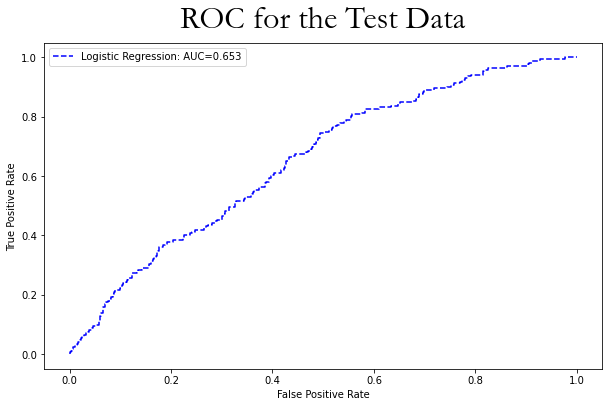

In [19]:
#try on test data

predicted = ml_model.predict(testX)
true_positives = np.sum((predicted==1)&(testY==1))
false_positives = np.sum((predicted==1)&(testY==0))
true_negatives = np.sum((predicted==0)&(testY==0))
false_negatives = np.sum((predicted==0)&(testY==1))

print("Precision is %03f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.2f" % (true_positives/(true_positives+false_negatives)))
confusion_matrix(predicted,testY)

fpr,tpr,thresholds = roc_curve(testY,
                               ml_model.predict_proba(testX)[:,1])
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,"b--",label="Logistic Regression: AUC=%0.3f"%(roc_auc_score(testY,ml_model.predict_proba(testX)[:,1])))
#plt.plot(thresholds,recall[:-1],"g-",label="recall")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for the Test Data',font='Garamond',fontsize=32,pad = 15)
plt.savefig('ROCfortheTestData_LogR.png')
plt.show()

<h2>Try on all the data</h2>

In [20]:
gd = goalie_data.sample(frac=1)
predicted = ml_model.predict(num_pipeline.fit_transform(gd[columns]))
gdY = np.array(gd['injured'])
true_positives = np.sum((predicted==1)&(gdY==1))
false_positives = np.sum((predicted==1)&(gdY==0))
true_negatives = np.sum((predicted==0)&(gdY==0))
false_negatives = np.sum((predicted==0)&(gdY==1))
print(false_positives)
print("Precision is %0.3f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.3f" % (true_positives/(true_positives+false_negatives)))

print('true_positives',true_positives)
print('false_positive',false_positives)
print('false_negative',false_negatives)
print('true_negative',true_negatives)

21586
Precision is 0.025
Recall is 0.636
true_positives 557
false_positive 21586
false_negative 319
true_negative 45697


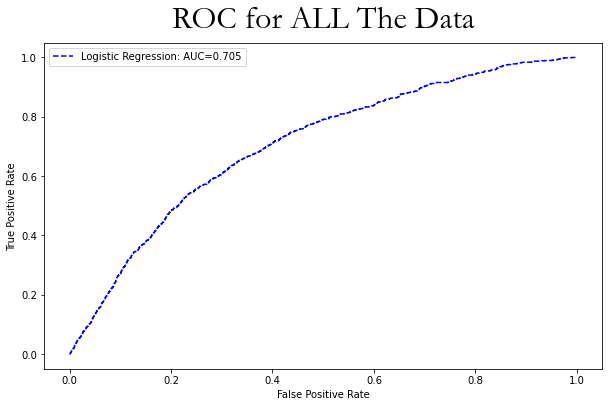

In [21]:
fpr,tpr,thresholds = roc_curve(np.array(gd['injured']),
                               ml_model.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1])
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,"b--",label="Logistic Regression: AUC=%0.3f"%(roc_auc_score(np.array(gd['injured']),ml_model.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1])))
#plt.plot(thresholds,recall[:-1],"g-",label="recall")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for ALL The Data',font='Garamond',fontsize=32,pad = 15)
plt.savefig('ROCforAlltheData.png')
plt.show()

In [22]:
ypred = ml_model.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1]
yreal = np.array(gd['injured'])
for m in np.arange(0,1,.1):
    tp = ((ypred>=m)&(yreal==1)).sum()
    fp = ((ypred>=m)&(yreal==0)).sum()
    fn = ((ypred<=m)&(yreal==1)).sum()

    print("Trial %0.2f:Identified %s of %s, Precision of %0.3f and Recall of %0.2f.  TP:%d,FP:%d"%(m,tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn),tp,fp))

Trial 0.00:Identified 876 of 876, Precision of 0.013 and Recall of 1.00.  TP:876,FP:67283
Trial 0.10:Identified 876 of 876, Precision of 0.013 and Recall of 1.00.  TP:876,FP:67283
Trial 0.20:Identified 876 of 876, Precision of 0.013 and Recall of 1.00.  TP:876,FP:67267
Trial 0.30:Identified 875 of 876, Precision of 0.013 and Recall of 1.00.  TP:875,FP:66335
Trial 0.40:Identified 855 of 876, Precision of 0.014 and Recall of 0.98.  TP:855,FP:58445
Trial 0.50:Identified 557 of 876, Precision of 0.025 and Recall of 0.64.  TP:557,FP:21586
Trial 0.60:Identified 325 of 876, Precision of 0.032 and Recall of 0.37.  TP:325,FP:9863
Trial 0.70:Identified 175 of 876, Precision of 0.034 and Recall of 0.20.  TP:175,FP:5043
Trial 0.80:Identified 56 of 876, Precision of 0.034 and Recall of 0.06.  TP:56,FP:1572
Trial 0.90:Identified 2 of 876, Precision of 0.018 and Recall of 0.00.  TP:2,FP:111


In [57]:
dump(ml_model,'BootstrappedLogR.joblib')

['BootstrappedLogR.joblib']